## Correlation: FFDI ~ LDsss (1950/51 to 2015/16) - Fire paper - Figure 1 - false discovery rate

In [1]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy as cart
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os import path
from pathlib import Path

%matplotlib inline

In [2]:
# Load FFDI NDJF average netcdf (calculated in FFDI_LDsss_correlation_v2)
ds_fire = xr.open_dataset('/g/data1a/v45/du2523/Monthly_calcs/FFDI_4mSeason_NDJF.nc')
ds_fire

0.3.0


<xarray.Dataset>
Dimensions:      (time: 70, lat: 691, lon: 886)
Coordinates:
  * time         (time) datetime64[ns] 1951-02-28 1952-02-29 ... 2020-02-29
  * lat          (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon          (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.2 156.2
Data variables:
    monthlyFFDI  (time, lat, lon) float32 ...

In [3]:
ds_fire = ds_fire.where(ds_fire.monthlyFFDI > 0, drop = True)
ds_fire

<xarray.Dataset>
Dimensions:      (time: 70, lat: 640, lon: 808)
Coordinates:
  * time         (time) datetime64[ns] 1951-02-28 1952-02-29 ... 2020-02-29
  * lat          (lat) float32 -43.6 -43.55 -43.5 -43.45 ... -10.85 -10.8 -10.75
  * lon          (lon) float32 113.2 113.3 113.3 113.4 ... 153.5 153.6 153.6
Data variables:
    monthlyFFDI  (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan

In [4]:
FFDI_subset = ds_fire.sel(time = slice('1951-02-28','2016-02-29'))

In [5]:
#load LDsss text file -> 
import pandas as pd

LDsss = pd.read_csv('/g/data1a/v45/du2523/ice_core_data/LawDome_DSS/LDsss_DJFM_1900_2016_vOct21_Jongetal.csv',
                   parse_dates=['JanYear'],
                   dayfirst = True)
#remove top row
#LDsss = LDsss.iloc[1:]
LDsss = LDsss.iloc[51:]

LDsss.head()

,JanYear,LDsss_DJFM
51,1951-01-01,0.217781
52,1952-01-01,0.244258
53,1953-01-01,0.170617
54,1954-01-01,0.138624
55,1955-01-01,0.135459


In [6]:
Year = LDsss['JanYear']
npdates = Year.to_numpy()
npdates

array(['1951-01-01T00:00:00.000000000', '1952-01-01T00:00:00.000000000',
       '1953-01-01T00:00:00.000000000', '1954-01-01T00:00:00.000000000',
       '1955-01-01T00:00:00.000000000', '1956-01-01T00:00:00.000000000',
       '1957-01-01T00:00:00.000000000', '1958-01-01T00:00:00.000000000',
       '1959-01-01T00:00:00.000000000', '1960-01-01T00:00:00.000000000',
       '1961-01-01T00:00:00.000000000', '1962-01-01T00:00:00.000000000',
       '1963-01-01T00:00:00.000000000', '1964-01-01T00:00:00.000000000',
       '1965-01-01T00:00:00.000000000', '1966-01-01T00:00:00.000000000',
       '1967-01-01T00:00:00.000000000', '1968-01-01T00:00:00.000000000',
       '1969-01-01T00:00:00.000000000', '1970-01-01T00:00:00.000000000',
       '1971-01-01T00:00:00.000000000', '1972-01-01T00:00:00.000000000',
       '1973-01-01T00:00:00.000000000', '1974-01-01T00:00:00.000000000',
       '1975-01-01T00:00:00.000000000', '1976-01-01T00:00:00.000000000',
       '1977-01-01T00:00:00.000000000', '1978-01-01

In [7]:
#set up parameters to create dataset from timeseries

lons = FFDI_subset.lon.values
lats = FFDI_subset.lat.values

LDsss_dates_col = LDsss.loc[:,'JanYear']
LDsss_dates = LDsss_dates_col.values
#LDsss_dates

LDsss_conc_col = LDsss.loc[:,'LDsss_DJFM']
LDsss_conc = LDsss_conc_col.values
#LDsss_conc
LDsss_conc.size

66

In [8]:
#FFDI dataset is time, lat, lon
nlons = lons.size
nlats = lats.size
ntime = LDsss_dates.size

LDsss_arr = np.zeros((ntime,nlats,nlons))
LDsss_arr.shape

(66, 640, 808)

In [9]:
LDsss_arr = np.zeros((ntime,nlats,nlons))
LDsss_fill = np.zeros((ntime,nlats,nlons))
#LDsss_fill[[0]].shape

n = LDsss_dates.size
for i in range(n):
    x = LDsss_conc[i]
    tmp = LDsss_arr[i,:,:]
    tmp[tmp == 0] = x
    LDsss_fill[[i]] = tmp

LDsss_fill.shape

(66, 640, 808)

In [10]:
#extract time from netcdf dataset to match for correlation
dates = FFDI_subset.time
dates.shape

dates_extend = ds_fire.time
dates_extend.shape

(70,)

In [11]:
#create an xarray dataset from the LDsss timeseries - using time, lat, lon from the netcdf dataset

ds_icecore = xr.Dataset({
    'LDsss':xr.DataArray(
        data = LDsss_fill, #enter data here - array must be the same size as the time, lat, lon dims/coords
        dims = ["time","lat","lon"],
        coords = {'time': dates,
                 'lat': lats,
                 'lon': lons},
        attrs = {
            '_FillValue':-999.9,
            'units': 'logCl'
        }
    )
}
)
ds_icecore

<xarray.Dataset>
Dimensions:  (time: 66, lat: 640, lon: 808)
Coordinates:
  * time     (time) datetime64[ns] 1951-02-28 1952-02-29 ... 2016-02-29
  * lat      (lat) float32 -43.6 -43.55 -43.5 -43.45 ... -10.85 -10.8 -10.75
  * lon      (lon) float32 113.2 113.3 113.3 113.4 ... 153.4 153.5 153.6 153.6
Data variables:
    LDsss    (time, lat, lon) float64 0.2178 0.2178 0.2178 ... 0.3387 0.3387

In [12]:
#ds_icecore.to_netcdf('/g/data/v45/du2523/FFDI_condition_counts/LDsss_1951-2016.nc')

In [13]:
#slice datasets to be the same length
LDsss = ds_icecore.LDsss.sel(time = slice('1951-02-28','2016-02-29'))
FFDI = ds_fire.monthlyFFDI.sel(time = slice('1951-02-28','2016-02-29')) 

In [14]:
FFDI.shape

(66, 640, 808)

In [16]:
FFDI_to2019_20 = ds_fire.monthlyFFDI.sel(time = slice('1951-02-28','2020-02-29')) 
FFDI_to2019_20

<xarray.DataArray 'monthlyFFDI' (time: 70, lat: 640, lon: 808)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1951-02-28 1952-02-29 ... 2020-02-29
  * lat      (lat) float32 -43.6 -43.55 -43.5 -43.45 ... -10.85 -10.8 -10.75
  * lon      (lon) float32 113.2 113.3 113.3 113.4 ... 153.4 153.5 153.6 153.6
Attributes:
    units:    monthlymeanFFDI

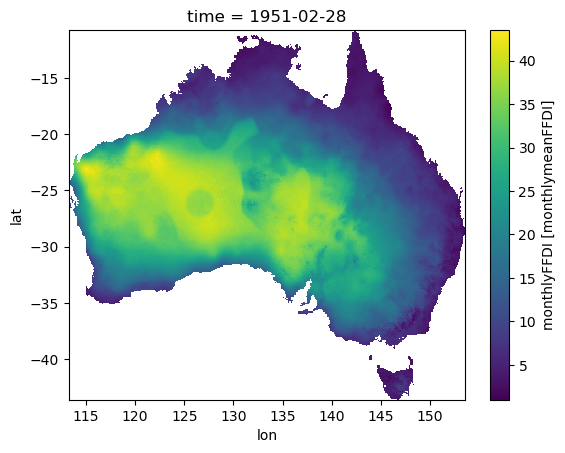

In [17]:
FFDI.sel(time = '1951-02-28').plot()

## Detrend

In [18]:
#Detrend function

def detrend_dim(da, dim, deg = 1):
    #detrend along a single dimension
    p = da.polyfit(dim = dim, deg = deg)
    fit = xr.polyval(da[dim],p.polyfit_coefficients)
    return da - fit

In [19]:
dFFDI = detrend_dim(FFDI,"time",1)
dLDsss = detrend_dim(LDsss,"time",1)

In [20]:
print(dLDsss.shape , dFFDI.shape)

(66, 640, 808) (66, 640, 808)


## Correlation

In [22]:
import xskillscore as xs
import warnings
warnings.filterwarnings("ignore")

In [23]:
#correlation with xskillscore
dcorr_r = xs.pearson_r(dLDsss, dFFDI, dim = "time", skipna = True)

In [24]:
#p value accounting for temporal autocorrelation
dcorr_eff_p = xs.pearson_r_eff_p_value(dLDsss, dFFDI, dim = "time", skipna = True)

In [25]:
# pa value - no autocorrelation
dcorr_p = xs.pearson_r_p_value(dLDsss, dFFDI, dim = "time", skipna = True)

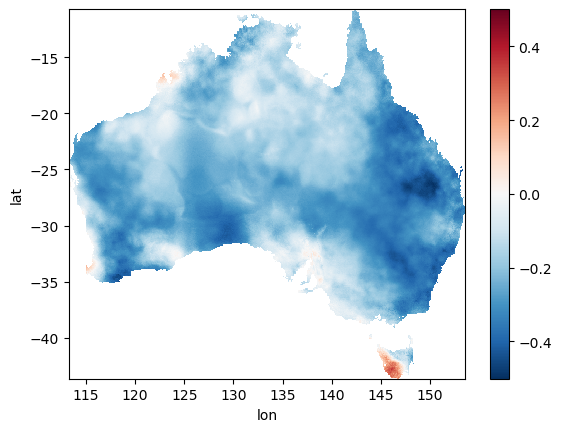

In [26]:
dcorr_r.plot()

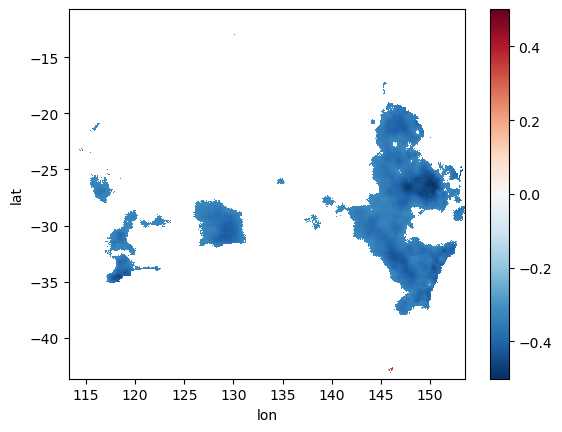

In [32]:
dcorr_r.where(dcorr_eff_p<0.01).plot()

In [33]:
#False Discovery Rates
p_df = dcorr_eff_p.to_dataframe(name = 'pvalues')
r_df = dcorr_r.to_dataframe(name = 'r')

In [34]:
p_df = p_df.dropna(axis = 0)
p_df_sorted = p_df.sort_values(by = ['pvalues'])
r_df = r_df.dropna(axis = 0)
r_df_sorted = r_df.sort_values(by = ['r'])

In [35]:
r_df_sorted

r
lat        lon                 
-26.650000 150.399994 -0.501240
-26.549999 150.500000 -0.499097
-26.350000 150.350006 -0.498422
           150.300003 -0.497372
-26.449999 150.399994 -0.497200
...                         ...
-42.750000 146.149994  0.352002
-42.799999 145.949997  0.355385
-42.750000 146.100006  0.357682
-42.849998 146.149994  0.360483
-42.799999 146.100006  0.365191

[278132 rows x 1 columns]

In [38]:
#merge dataframes
df_r_p = pd.concat([r_df_sorted, p_df_sorted], axis = 1)
df_r_p

r   pvalues
lat        lon                           
-26.650000 150.399994 -0.501240  0.000018
-26.549999 150.500000 -0.499097  0.000023
-26.350000 150.350006 -0.498422  0.000024
           150.300003 -0.497372  0.000025
-26.449999 150.399994 -0.497200  0.000022
...                         ...       ...
-42.750000 146.149994  0.352002  0.003750
-42.799999 145.949997  0.355385  0.003409
-42.750000 146.100006  0.357682  0.003442
-42.849998 146.149994  0.360483  0.002946
-42.799999 146.100006  0.365191  0.002570

[278132 rows x 2 columns]

In [40]:
pvals = df_r_p.iloc[:,1]
pvals.shape

(278132,)

In [42]:
import statsmodels.api as sm

In [43]:
#https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html
#https://www.youtube.com/watch?v=c9-zvw3AY3Q 
qvals = sm.stats.multipletests(pvals, alpha = 0.05, method = "fdr_bh")

In [44]:
qvals

(array([ True,  True,  True, ...,  True,  True,  True]),
 array([0.03344999, 0.03344999, 0.03344999, ..., 0.03416595, 0.03372792,
        0.03361004]),
 1.8442066951340763e-07,
 1.7977075633152604e-07)

In [45]:
qvals[1]

array([0.03344999, 0.03344999, 0.03344999, ..., 0.03416595, 0.03372792,
       0.03361004])

In [47]:
df_r_p['qvals'] = qvals[1]
df_r_p

r   pvalues     qvals
lat        lon                                     
-26.650000 150.399994 -0.501240  0.000018  0.033450
-26.549999 150.500000 -0.499097  0.000023  0.033450
-26.350000 150.350006 -0.498422  0.000024  0.033450
           150.300003 -0.497372  0.000025  0.033450
-26.449999 150.399994 -0.497200  0.000022  0.033450
...                         ...       ...       ...
-42.750000 146.149994  0.352002  0.003750  0.034522
-42.799999 145.949997  0.355385  0.003409  0.034138
-42.750000 146.100006  0.357682  0.003442  0.034166
-42.849998 146.149994  0.360483  0.002946  0.033728
-42.799999 146.100006  0.365191  0.002570  0.033610

[278132 rows x 3 columns]

In [56]:
df_r_p.to_csv('/g/data/v45/du2523/Fire_paper_scripts_figures/LDsss_FFDI_r_peff_qvals.csv')

In [67]:
#subset dataframe to qvals <0.05
qval_lt_0pt05 = df_r_p[df_r_p['qvals']<0.05]
qval_lt_0pt05

r   pvalues     qvals
lat        lon                                     
-26.650000 150.399994 -0.501240  0.000018  0.033450
-26.549999 150.500000 -0.499097  0.000023  0.033450
-26.350000 150.350006 -0.498422  0.000024  0.033450
           150.300003 -0.497372  0.000025  0.033450
-26.449999 150.399994 -0.497200  0.000022  0.033450
...                         ...       ...       ...
-42.750000 146.149994  0.352002  0.003750  0.034522
-42.799999 145.949997  0.355385  0.003409  0.034138
-42.750000 146.100006  0.357682  0.003442  0.034166
-42.849998 146.149994  0.360483  0.002946  0.033728
-42.799999 146.100006  0.365191  0.002570  0.033610

[54955 rows x 3 columns]

In [68]:
#subset dataframe to pvalue <0.05
pval_lt_0pt05 = df_r_p[df_r_p['pvalues']<0.05]
pval_lt_0pt05

r   pvalues     qvals
lat        lon                                     
-26.650000 150.399994 -0.501240  0.000018  0.033450
-26.549999 150.500000 -0.499097  0.000023  0.033450
-26.350000 150.350006 -0.498422  0.000024  0.033450
           150.300003 -0.497372  0.000025  0.033450
-26.449999 150.399994 -0.497200  0.000022  0.033450
...                         ...       ...       ...
-42.750000 146.149994  0.352002  0.003750  0.034522
-42.799999 145.949997  0.355385  0.003409  0.034138
-42.750000 146.100006  0.357682  0.003442  0.034166
-42.849998 146.149994  0.360483  0.002946  0.033728
-42.799999 146.100006  0.365191  0.002570  0.033610

[121211 rows x 3 columns]

In [69]:
#subset dataframe to pvalue <0.01
pval_lt_0pt01 = df_r_p[df_r_p['pvalues']<0.01]
pval_lt_0pt01

r   pvalues     qvals
lat        lon                                     
-26.650000 150.399994 -0.501240  0.000018  0.033450
-26.549999 150.500000 -0.499097  0.000023  0.033450
-26.350000 150.350006 -0.498422  0.000024  0.033450
           150.300003 -0.497372  0.000025  0.033450
-26.449999 150.399994 -0.497200  0.000022  0.033450
...                         ...       ...       ...
-42.750000 146.149994  0.352002  0.003750  0.034522
-42.799999 145.949997  0.355385  0.003409  0.034138
-42.750000 146.100006  0.357682  0.003442  0.034166
-42.849998 146.149994  0.360483  0.002946  0.033728
-42.799999 146.100006  0.365191  0.002570  0.033610

[55354 rows x 3 columns]

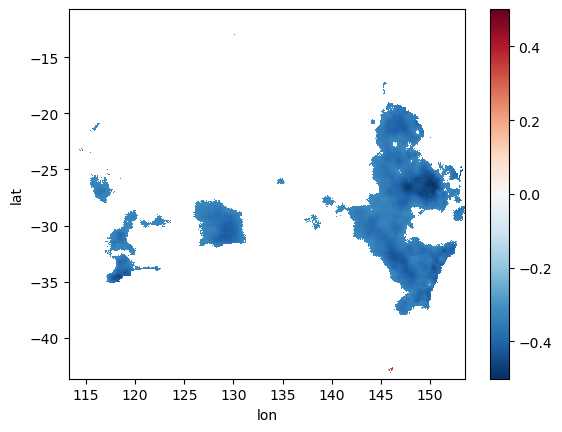

In [70]:
#adjusted significance accounting for multiple testing
#qval = 0.05 = pval = 0.009879 = r = -0.31545

#previous maps
#pval = 0.05 = r = -0.24
#pval = 0.01 = r = -0.31735

dcorr_r.where(dcorr_eff_p<0.01).plot()

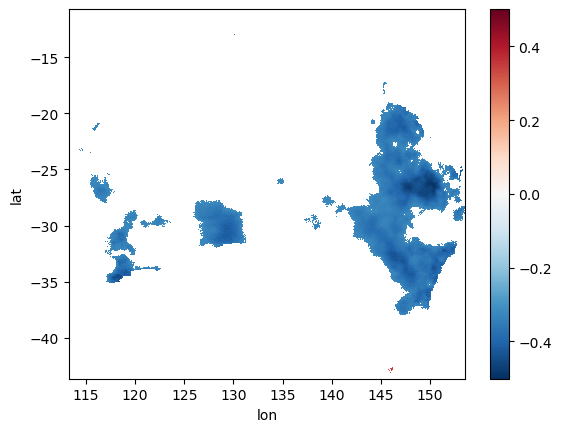

In [71]:
dcorr_r.where(dcorr_eff_p<0.009879).plot()

In [72]:
maxcorr = dcorr_r.max().values
mincorr = dcorr_r.min().values
mincorr, maxcorr

(array(-0.50123992), array(0.36519141))

In [73]:
#add polygon of reconstruction region
#geospatial plots
from rasterstats import zonal_stats
import rasterio
import os
import geopandas as gpd

shpfile = gpd.read_file('/g/data1a/v45/du2523/shp_files/ESB_lines_ACT_and_VicAlps_added_Hunter_Lakes_Entrance_valid_geometry.shp')
#remove none rows
shp = shpfile
shp = shp[shp.geom_type == 'MultiPolygon']
shp

,Id,Name,geometry
0,1,ESB2,"MULTIPOLYGON (((147.96109 -37.89161, 147.94878..."


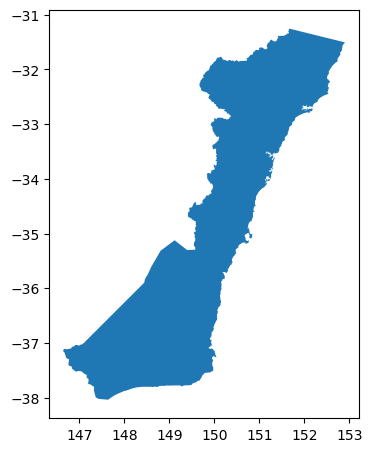

In [74]:
fig, ax = plt.subplots(figsize = (4,8))
shp.plot(ax = ax)
plt.show()

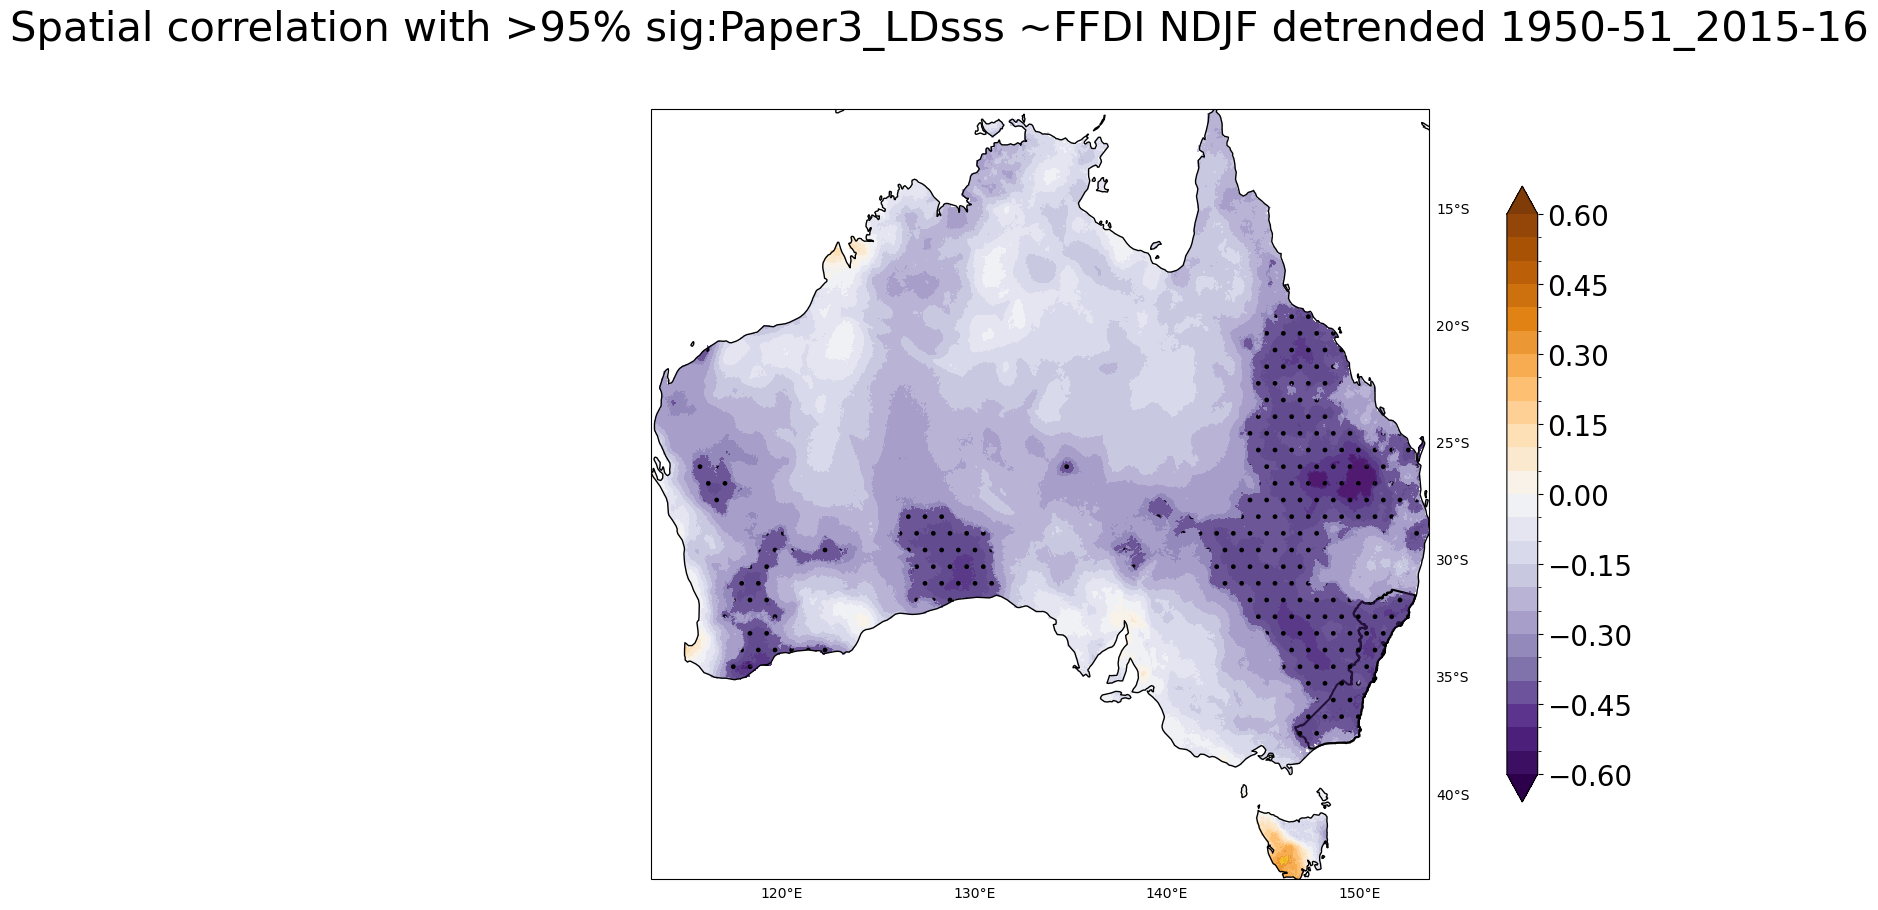

In [109]:
#signficance calculation above
corr = dcorr_r
#sig_cor = dcorr_r.where(dcorr_eff_p<0.05) 
sig_corr = dcorr_r.where(dcorr_eff_p<0.01) #accounting for false discovery rate
x = sig_corr.lon
y = sig_corr.lat
z = sig_corr

output = '/g/data/v45/du2523/Fire_paper_scripts_figures/'

fig = plt.figure(figsize = [20,10])
ax = fig.add_subplot(111, projection = ccrs.PlateCarree())

levels = np.arange(-0.6,0.65,0.05)
#ID = 'LDsss_FFDI_corr_sig'
var = 'Paper3_LDsss'
period = '1950-51_2015-16'
ID = 'FFDI_corr_NDJF_detrend_temp_spat_autocorr_sig95_FDR'
region = 'Aus'

#either corr or dcorr

cp = corr.plot.contourf(ax = ax,
                        levels = levels,
                        extend = 'both',
                        cmap = 'PuOr_r',
                        transform = ccrs.PlateCarree(),
                        add_colorbar = False)

shp.plot(ax = ax, color = 'none', edgecolor = 'black', linewidth = 1.5)

hatch = ax.contourf(x,y,z, hatches=['.'],extend = 'both', alpha = 0.5)

cb = fig.colorbar(cp, ax = ax, shrink = 0.8)
for t in cb.ax.get_yticklabels():
    t.set_fontsize(20)
    
ax.coastlines()
#ax.add_feature(cart.feature.OCEAN,zorder=100, edgecolor='k', facecolor = 'w')
#ax.add_feature(cart.feature.RIVERS,zorder=100,edgecolor='k')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.01, color='grey', alpha=0.1, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
    
fig.suptitle('Spatial correlation with >95% sig:'+ var + ' ~FFDI NDJF detrended ' + period,fontsize = 30)

#save figure
fig.savefig(output + var + '_'+ ID +'_'+ period + '_' + region  +'.jpg')
fig.savefig(output + var + '_'+ ID +'_'+ period + '_' + region  +'.pdf', format = "pdf")